<a href="https://colab.research.google.com/github/Chinmaya-3141/Capstone-Project/blob/main/Capstone_Object_Detection_Pretrained_model_full_freeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Object Detection using Pytorch Faster RCNN Resnet-50-FPN model**

## Install, import necessary packages, global variables

In [ ]:
# Mount Drive to import Data

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%time
!pip install torchinfo -qq

CPU times: user 25.6 ms, sys: 13 ms, total: 38.5 ms
Wall time: 4.03 s


In [ ]:
%%time
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI' -qq

  Preparing metadata (setup.py) ... done
CPU times: user 84.6 ms, sys: 21.4 ms, total: 106 ms
Wall time: 13.9 s


In [ ]:
%%time
!git clone https://github.com/pytorch/vision.git
!cd vision;cp references/detection/utils.py ../;cp references/detection/transforms.py ../;cp references/detection/coco_eval.py ../;cp references/detection/engine.py ../;cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 322053, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 322053 (delta 12), reused 29 (delta 9), pack-reused 322015
Receiving objects: 100% (322053/322053), 651.89 MiB | 25.43 MiB/s, done.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [ ]:
import os
import random
import math
import sys
import time
import tqdm
from tqdm import trange
import shutil
from skimage import io
import cv2
from albumentations.pytorch import ToTensorV2
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip,
                            Normalize,Flip, Compose, GaussNoise)
# import albumentations as A

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn as fasterrcnn
from torch.utils.data import DataLoader, Dataset
from torchvision import utils
from torchvision import transforms
from torchinfo import summary as tisum
from torch.optim import AdamW, RMSprop
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, OneCycleLR

# from engine import train_one_epoch, evaluate
# from torchvision.models.detection import retinanet_resnet50_fpn as retinanet
# from torchvision.models.detection import FasterRCNN
# from torchvision.models.detection.rpn import AnchorGenerator
# from torch.utils.data.sampler import SequentialSampler
# from torchvision.models.detection.transform import GeneralizedRCNNTransform as g_trans

In [ ]:
from engine import train_one_epoch, evaluate
import utils

In [ ]:
# To improve reproducibility

def seed_everything(seed=42):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [ ]:
seed_everything(42)

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.0.0+cu118
0.15.1+cu118


In [ ]:
batchsize = 16
channels = 3
dimension = 640
learning_rate = 0.005
weight_decay = 0.0005
num_epochs = 10

## Import, Explore Data

In [ ]:
csv_path = '/content/drive/MyDrive/Capstone Data (Shared)/Capstone Data/For Object Detection/Object_detection_640_corrected.csv'
train_dir = '/content/drive/MyDrive/Capstone Data (Shared)/Capstone Data/For Object Detection/Combined_640_images of Covid and Pneumonia _for FasterRCNN'

In [ ]:
df = pd.read_csv(csv_path)
df.head(16)

,filename,width,height,bbox,label,xmin,ymin,xmax,ymax,box_w,box_h
0,COVID-100.png,640,640,"[204, 192, 478, 530]",covid,204,192,478,530,274,338
1,COVID-101.png,640,640,"[196, 140, 484, 444]",covid,196,140,484,444,288,304
2,COVID-103.png,640,640,"[166, 140, 462, 482]",covid,166,140,462,482,296,342
3,COVID-104.png,640,640,"[192, 158, 490, 508]",covid,192,158,490,508,298,350
4,COVID-105.png,640,640,"[152, 122, 432, 516]",covid,152,122,432,516,280,394
5,COVID-106.png,640,640,"[182, 134, 436, 496]",covid,182,134,436,496,254,362
6,COVID-107.png,640,640,"[198, 138, 470, 464]",covid,198,138,470,464,272,326
7,COVID-108.png,640,640,"[234, 232, 474, 514]",covid,234,232,474,514,240,282
8,COVID-109.png,640,640,"[200, 162, 458, 514]",covid,200,162,458,514,258,352
9,COVID-10.png,640,640,"[190, 180, 492, 504]",covid,190,180,492,504,302,324


In [ ]:
# Checking the data

print(f'Total number of train images is {len(os.listdir(train_dir))}')
print(f'shape of dataframe is {df.shape}')
print(f'Number of images in dataframe is {len(np.unique(df["filename"]))}')
print(f'Number of train images with no bounding boxes {len(os.listdir(train_dir)) - len(np.unique(df["filename"]))}')

Total number of train images is 925
shape of dataframe is (2601, 11)
Number of images in dataframe is 925
Number of train images with no bounding boxes 0


In [ ]:
# If images without bounding boxes exist, list them

for var in os.listdir(train_dir):
  if var not in np.unique(df["filename"]):
    print(var)

In [ ]:
df['label'].unique()

array(['covid', 'pneumonia'], dtype=object)

In [ ]:
# Label encoding classes

enc = preprocessing.LabelEncoder()
df['enc_labels'] = enc.fit_transform(df['label'])   # label encode classes 0-1
df['enc_labels'] = np.stack(df['enc_labels'][i]+1 for i in range(len(df['enc_labels'])))    # label encode classes 1-2

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
classes = df[['label','enc_labels']].value_counts()
classes

label      enc_labels
pneumonia  2             1492
covid      1             1109
dtype: int64

In [ ]:
# make dictionary for class objects so we can call objects by their keys.
classes= {0:'background', 1:'covid',2:'pneumonia'}

In [ ]:
df.head()

,filename,width,height,bbox,label,xmin,ymin,xmax,ymax,box_w,box_h,enc_labels
0,COVID-100.png,640,640,"[204, 192, 478, 530]",covid,204,192,478,530,274,338,1
1,COVID-101.png,640,640,"[196, 140, 484, 444]",covid,196,140,484,444,288,304,1
2,COVID-103.png,640,640,"[166, 140, 462, 482]",covid,166,140,462,482,296,342,1
3,COVID-104.png,640,640,"[192, 158, 490, 508]",covid,192,158,490,508,298,350,1
4,COVID-105.png,640,640,"[152, 122, 432, 516]",covid,152,122,432,516,280,394,1


## Stratified sampling

In [ ]:
df['filename'].nunique()

925

In [ ]:
# Split the data in roughly equal proportions of each class into train and test in given ratio (80-20 usually).

def stratified_sampling(dataframe, proportion, column_name, filename):
    # Group the dataframe by the column and filename to split based on
    grouped_dataframe = dataframe.groupby([column_name, filename])

    # Initialize empty dataframes for the training and validation sets
    train_dataframe = pd.DataFrame()
    val_dataframe = pd.DataFrame()

    # Loop through each group and add the entire group to either the training or validation dataframe,
    # depending on a randomly generated value for that group
    for _, group in grouped_dataframe:
        if random.random() >= proportion: # Stochastic element introduced here
            val_dataframe = pd.concat([val_dataframe, group])
        else:
            train_dataframe = pd.concat([train_dataframe, group])

    # Reset the index of the dataframes
    train_dataframe = train_dataframe.reset_index(drop=True)
    val_dataframe = val_dataframe.reset_index(drop=True)

    return train_dataframe, val_dataframe


In [ ]:
# Count the number of images for covid and pneumonia in split dataframe

def count_unique_filenames(df):
    # Filter the DataFrame to only include rows with "covid" or "pneumonia" labels
    covid_pneumonia_df = df[df['label'].isin(['covid', 'pneumonia'])]

    # Count the number of unique filenames with "covid" and "pneumonia" labels separately
    covid_filenames = covid_pneumonia_df[covid_pneumonia_df['label'] == 'covid']['filename'].nunique()
    pneumonia_filenames = covid_pneumonia_df[covid_pneumonia_df['label'] == 'pneumonia']['filename'].nunique()

    # Print output
    print(f"Unique filenames with Covid label:", covid_filenames)
    print(f"Unique filenames with Pneumonia label:", pneumonia_filenames)

    return covid_filenames, pneumonia_filenames

In [ ]:
# Split the dataframe and images

train, val = stratified_sampling(df,0.8,'label','filename')

In [ ]:
# Check if any filenames coincide

for i in train['filename']:
  if(i in val['filename']):
    print(i)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2042 entries, 0 to 2041
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    2042 non-null   object
 1   width       2042 non-null   int64 
 2   height      2042 non-null   int64 
 3   bbox        2042 non-null   object
 4   label       2042 non-null   object
 5   xmin        2042 non-null   int64 
 6   ymin        2042 non-null   int64 
 7   xmax        2042 non-null   int64 
 8   ymax        2042 non-null   int64 
 9   box_w       2042 non-null   int64 
 10  box_h       2042 non-null   int64 
 11  enc_labels  2042 non-null   int64 
dtypes: int64(9), object(3)
memory usage: 191.6+ KB


In [ ]:
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559 entries, 0 to 558
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    559 non-null    object
 1   width       559 non-null    int64 
 2   height      559 non-null    int64 
 3   bbox        559 non-null    object
 4   label       559 non-null    object
 5   xmin        559 non-null    int64 
 6   ymin        559 non-null    int64 
 7   xmax        559 non-null    int64 
 8   ymax        559 non-null    int64 
 9   box_w       559 non-null    int64 
 10  box_h       559 non-null    int64 
 11  enc_labels  559 non-null    int64 
dtypes: int64(9), object(3)
memory usage: 52.5+ KB


In [ ]:
cf_total,pf_total = count_unique_filenames(df)

Unique filenames with Covid label: 479
Unique filenames with Pneumonia label: 446


In [ ]:
cf_train, pf_train = count_unique_filenames(train)

Unique filenames with Covid label: 374
Unique filenames with Pneumonia label: 362


In [ ]:
cf_val, pf_val = count_unique_filenames(val)

Unique filenames with Covid label: 105
Unique filenames with Pneumonia label: 84


In [ ]:
print(f"Covid (fraction of total data): {round((cf_total/(cf_total + pf_total))*100,3)}%")
print(f"Pneumonia (fraction of total data): {round((pf_total/(cf_total + pf_total))*100,3)}%")

Covid (fraction of total data): 51.784%
Pneumonia (fraction of total data): 48.216%


In [ ]:
print(f"Covid Train (fraction of covid): {round((cf_train/cf_total)*100,3)}%, Pneumonia Train (fraction of pneumonia): {round((pf_train/pf_total)*100,3)}%")
print(f"Covid Train (fraction of train): {round((cf_train/(cf_train + pf_train))*100,3)}%, Pneumonia Train (fraction of train): {round((pf_train/(cf_train+pf_train))*100,3)}%")

Covid Train (fraction of covid): 78.079%, Pneumonia Train (fraction of pneumonia): 81.166%
Covid Train (fraction of train): 50.815%, Pneumonia Train (fraction of train): 49.185%


In [ ]:
print(f"Covid Test(fraction of covid): {round((cf_val/cf_total)*100,3)}%, Pneumonia Test (fraction of pneumonia): {round((pf_val/pf_total)*100,3)}%")
print(f"Covid Test (fraction of validation): {round((cf_val/(cf_val + pf_val))*100,3)}%, Pneumonia Test (fraction of validation): {round((pf_val/(cf_val+pf_val))*100,3)}%")

Covid Test(fraction of covid): 21.921%, Pneumonia Test (fraction of pneumonia): 18.834%
Covid Test (fraction of validation): 55.556%, Pneumonia Test (fraction of validation): 44.444%


In [ ]:
A = df[df['filename']== 'COVID-113.png']['label'].values
A

array(['covid', 'covid'], dtype=object)

## Transforms, Custom DatasetClass, Dataloader

In [ ]:
def get_transform():
    list_transforms = []
    # converts the input image, which should be a PIL image, into a PyTorch Tensor
    list_transforms.append(transforms.ToTensor())

    #keeping space for augmentations in future

    return transforms.Compose(list_transforms)

**Getitem returns for EACH image:**

1.   **image** - a PIL image of size (H,W)

    for ResNet50 FPN image should be scaled

2.   **target** - a dictionary containing the following fields

    1. ***Boxes*** as FloatTensor of dimensions - (N,4)
      
      here, N = number of bounding boxs within an image and the 4 columns include [x_min, y_min, x_max, y_max]
    2. ***Labels*** as Int64Tensor of dimension - N

    3. ***Area*** as Int64Tensor of dimension - N

    4. ***Iscrowd*** as UInt8Tensor of dimension - N

3. (removed) **image_id** - Name of the image


In [ ]:
class XrayData(Dataset):
    def __init__(self,input_df,input_dir,transforms=None):
        super().__init__()
        self.df=input_df
        self.list_images = list(self.df['filename'].unique())
        self.image_dir=input_dir
        self.transforms = transforms
        self.label_mapping = {0: "background", 1: "covid", 2: "pneumonia"}

    def __len__(self):
        return len(self.df['filename'].unique())

    def get_label_mapping(self):
        return self.label_mapping

    def __getitem__(self,idx):

        cols_to_be_selected =['xmin','ymin','xmax','ymax']
        img_id = self.list_images[idx]
        bboxes_array = np.array(self.df.loc[self.df['filename']==img_id,cols_to_be_selected])
        boxes = torch.tensor(bboxes_array, dtype=torch.float32)

        num_boxes = self.df.loc[self.df['filename']==img_id].shape[0]
        label = self.df[self.df['filename']== img_id]['enc_labels'].values
        labels = torch.as_tensor(label, dtype=torch.int64)

        area = torch.tensor(np.array((self.df['xmax']-self.df['xmin'])*(self.df['ymax']-self.df['ymin'])), dtype=torch.int64)

        iscrowd = torch.zeros(num_boxes, dtype=torch.uint8)

        # Combining everything
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowd'] = iscrowd

        # img = cv2.imread(os.path.join(self.image_dir, img_id), 0)  # 0 for grayscale
        img = cv2.imread(self.image_dir+'/'+img_id, cv2.IMREAD_COLOR)
        img_col = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_scaled = img_col / 255.0
        img_final = img_scaled

        if self.transforms is not None:
            img_final = self.transforms(img_final)

        return img_final, target

In [ ]:
train_dataset = XrayData(train,train_dir,get_transform())
val_dataset = XrayData(val,train_dir,get_transform())

In [ ]:
print(f'Length of train data {len(train_dataset)}')
print(f'Length of validation data {len(val_dataset)}')

Length of train data 736
Length of validation data 189


In [ ]:
# batching
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_data_loader = DataLoader(
    train_dataset,
    batch_size=batchsize,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    val_dataset,
    batch_size=batchsize,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

In [ ]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data,idx):
    out = data.__getitem__(idx) # Has (image, target, image_id) for idx
    image = image_convert(out[0])
    image = np.ascontiguousarray(image)
    bb = out[1]['boxes'].numpy() # target boxes coordinates to numpy
    sample = out[1]['labels'].numpy()
    print(data.label_mapping)
    for i in bb:
        cv2.rectangle(image, (int(i[0]),int(i[1])), (int(i[2]),int(i[3])), (0,255,0), thickness=2)
    for idx, i in enumerate(sample):
        label = data.label_mapping[i]
        x, y = int(bb[idx][0]), int(bb[idx][1])
        cv2.putText(image, label, (x, y-5), cv2.FONT_HERSHEY_COMPLEX, 0.7, (220,0,0), 1, cv2.LINE_AA)

    plt.figure(figsize=(10,10))
    plt.imshow(image)

In [ ]:
# train_dataset[124]

{0: 'background', 1: 'covid', 2: 'pneumonia'}


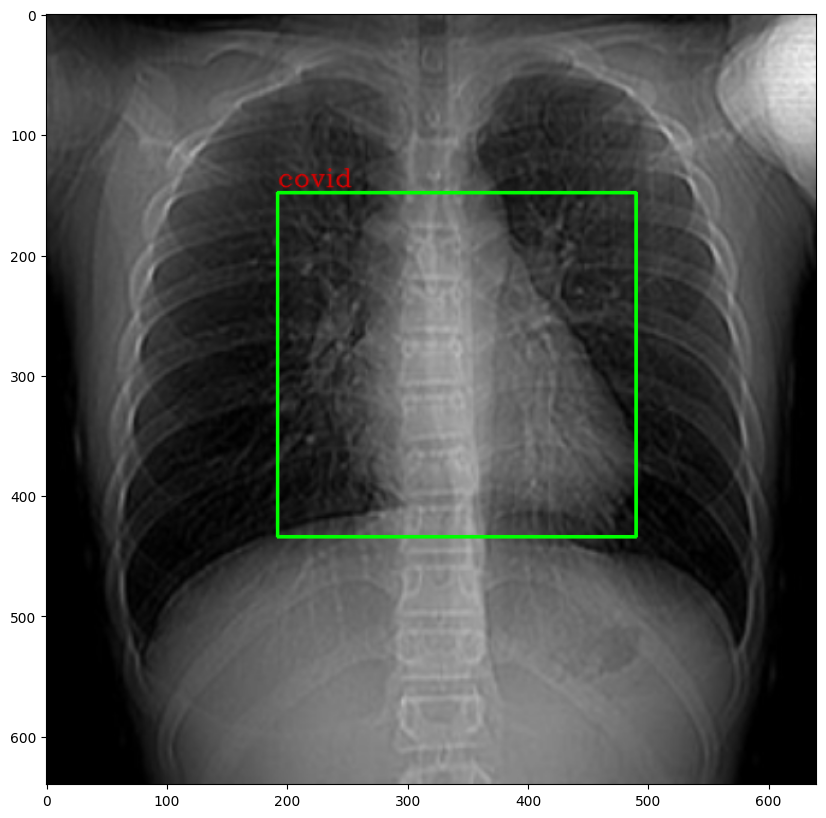

In [ ]:
plot_img(train_dataset, 20) # Range from 0 to 745 for train, 0 to 125 for val

## Training a model, Saving model

In [ ]:
torch.cuda.empty_cache()

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
# define the number of classes
num_classes = 3  # COVID, pneumonia, background already taken as 0 by default

# load a pre-trained model
model = fasterrcnn(pretrained=True)

# get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 94.1MB/s]


In [ ]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# params = [p for p in model.parameters() if p.requires_grad]

# optimizer = torch.optim.SGD(params, lr=0.005, weight_decay=0.0005)
# optimizer = AdamW(params, lr=learning_rate, weight_decay=weight_decay)

# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# lr_scheduler = CosineAnnealingLR(optimizer,T_max = 100, eta_min = 10e-6, verbose = True)

# Set the requires_grad attribute to False for all parameters in the model
for param in model.parameters():
    param.requires_grad = False

params = []
# Set the requires_grad attribute to True for the parameters of the new head (FastRCNNPredictor)
for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = True
    params.append(param)

# Define your optimizer
optimizer = AdamW(params, lr=1e-3, weight_decay=1e-5)

# Define your learning rate scheduler
lr_scheduler = OneCycleLR(optimizer, max_lr=1e-2, epochs=num_epochs, steps_per_epoch=len(train_data_loader))


In [ ]:
import multiprocessing
print("Number of CPU cores:", multiprocessing.cpu_count())

Number of CPU cores: 2


In [ ]:
print(tisum(
    model,
    input_size = (batchsize,channels,dimension,dimension),
    depth =6
    ))

Layer (type:depth-idx)                                  Output Shape              Param #
FasterRCNN                                              [100, 4]                  --
├─GeneralizedRCNNTransform: 1-1                         [16, 3, 800, 800]         --
├─BackboneWithFPN: 1-2                                  [16, 256, 13, 13]         --
│    └─IntermediateLayerGetter: 2-1                     [16, 2048, 25, 25]        --
│    │    └─Conv2d: 3-1                                 [16, 64, 400, 400]        (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      [16, 64, 400, 400]        --
│    │    └─ReLU: 3-3                                   [16, 64, 400, 400]        --
│    │    └─MaxPool2d: 3-4                              [16, 64, 200, 200]        --
│    │    └─Sequential: 3-5                             [16, 256, 200, 200]       --
│    │    │    └─Bottleneck: 4-1                        [16, 256, 200, 200]       --
│    │    │    │    └─Conv2d: 5-1                      

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


In [ ]:
%%time
# let's train it for n epochs
for epoch in trange(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)

    # update the learning rate
    lr_scheduler.step()

    # evaluate on the test dataset
    evaluate(model, valid_data_loader, device=device)

    # Write code to save model here
    torch.save(model.state_dict(), f'faster_rcnn_state_{epoch+1}_epoch.pt')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: [0]  [ 0/46]  eta: 0:11:56  lr: 0.000009  loss: 1.5210 (1.5210)  loss_classifier: 1.3678 (1.3678)  loss_box_reg: 0.1118 (0.1118)  loss_objectness: 0.0236 (0.0236)  loss_rpn_box_reg: 0.0178 (0.0178)  time: 15.5793  data: 13.5328  max mem: 7064
Epoch: [0]  [10/46]  eta: 0:01:38  lr: 0.000098  loss: 1.6604 (1.7906)  loss_classifier: 1.3578 (1.3327)  loss_box_reg: 0.1099 (0.1109)  loss_objectness: 0.1751 (0.3119)  loss_rpn_box_reg: 0.0197 (0.0352)  time: 2.7408  data: 1.3522  max mem: 7073
Epoch: [0]  [20/46]  eta: 0:00:52  lr: 0.000187  loss: 1.5253 (1.5849)  loss_classifier: 1.1460 (1.1313)  loss_box_reg: 0.0990 (0.1035)  loss_objectness: 0.2419 (0.3138)  loss_rpn_box_reg: 0.0294 (0.0362)  time: 1.3327  data: 0.1122  max mem: 7073
Epoch: [0]  [30/46]  eta: 0:00:27  lr: 0.000276  loss: 0.8357 (1.2890)  loss_classifier: 0.6026 (0.8887)  loss_box_reg: 0.0891 (0.0922)  loss_objectness: 0.2356 (0.2760)  loss_rpn_box_reg: 0.0259 (0.0320)  time: 1.1776  data: 0.0788  max mem: 7073
Epoch:

 10%|█         | 1/10 [01:30<13:31, 90.16s/it]

Epoch: [1]  [ 0/46]  eta: 0:01:26  lr: 0.000401  loss: 0.3126 (0.3126)  loss_classifier: 0.1583 (0.1583)  loss_box_reg: 0.1117 (0.1117)  loss_objectness: 0.0249 (0.0249)  loss_rpn_box_reg: 0.0178 (0.0178)  time: 1.8807  data: 0.8052  max mem: 7073
Epoch: [1]  [10/46]  eta: 0:00:44  lr: 0.000401  loss: 0.4687 (0.6246)  loss_classifier: 0.1583 (0.1758)  loss_box_reg: 0.0980 (0.1015)  loss_objectness: 0.1747 (0.3121)  loss_rpn_box_reg: 0.0197 (0.0352)  time: 1.2242  data: 0.1321  max mem: 7073
Epoch: [1]  [20/46]  eta: 0:00:31  lr: 0.000401  loss: 0.5578 (0.6234)  loss_classifier: 0.1797 (0.1778)  loss_box_reg: 0.0898 (0.0962)  loss_objectness: 0.2398 (0.3131)  loss_rpn_box_reg: 0.0294 (0.0362)  time: 1.1661  data: 0.0654  max mem: 7073
Epoch: [1]  [30/46]  eta: 0:00:18  lr: 0.000401  loss: 0.4692 (0.5531)  loss_classifier: 0.1658 (0.1605)  loss_box_reg: 0.0845 (0.0853)  loss_objectness: 0.2338 (0.2753)  loss_rpn_box_reg: 0.0259 (0.0320)  time: 1.1645  data: 0.0662  max mem: 7073
Epoch: [

 20%|██        | 2/10 [02:43<10:39, 79.99s/it]

Epoch: [2]  [ 0/46]  eta: 0:01:30  lr: 0.000405  loss: 0.3108 (0.3108)  loss_classifier: 0.1713 (0.1713)  loss_box_reg: 0.0992 (0.0992)  loss_objectness: 0.0225 (0.0225)  loss_rpn_box_reg: 0.0178 (0.0178)  time: 1.9635  data: 0.8742  max mem: 7073
Epoch: [2]  [10/46]  eta: 0:00:44  lr: 0.000405  loss: 0.4881 (0.6304)  loss_classifier: 0.1713 (0.1815)  loss_box_reg: 0.0995 (0.1019)  loss_objectness: 0.1745 (0.3118)  loss_rpn_box_reg: 0.0197 (0.0352)  time: 1.2427  data: 0.1399  max mem: 7073
Epoch: [2]  [20/46]  eta: 0:00:31  lr: 0.000405  loss: 0.5463 (0.6196)  loss_classifier: 0.1638 (0.1741)  loss_box_reg: 0.0934 (0.0962)  loss_objectness: 0.2377 (0.3130)  loss_rpn_box_reg: 0.0294 (0.0362)  time: 1.1724  data: 0.0683  max mem: 7073
Epoch: [2]  [30/46]  eta: 0:00:19  lr: 0.000405  loss: 0.4589 (0.5475)  loss_classifier: 0.1524 (0.1556)  loss_box_reg: 0.0811 (0.0848)  loss_objectness: 0.2336 (0.2752)  loss_rpn_box_reg: 0.0259 (0.0320)  time: 1.1832  data: 0.0710  max mem: 7073
Epoch: [

 30%|███       | 3/10 [03:56<09:00, 77.21s/it]

Epoch: [3]  [ 0/46]  eta: 0:02:00  lr: 0.000411  loss: 0.2758 (0.2758)  loss_classifier: 0.1206 (0.1206)  loss_box_reg: 0.1123 (0.1123)  loss_objectness: 0.0251 (0.0251)  loss_rpn_box_reg: 0.0178 (0.0178)  time: 2.6186  data: 1.3185  max mem: 7073
Epoch: [3]  [10/46]  eta: 0:00:47  lr: 0.000411  loss: 0.4341 (0.5745)  loss_classifier: 0.1206 (0.1307)  loss_box_reg: 0.0977 (0.0959)  loss_objectness: 0.1773 (0.3127)  loss_rpn_box_reg: 0.0197 (0.0352)  time: 1.3092  data: 0.1803  max mem: 7073
Epoch: [3]  [20/46]  eta: 0:00:32  lr: 0.000411  loss: 0.4985 (0.5683)  loss_classifier: 0.1189 (0.1254)  loss_box_reg: 0.0927 (0.0931)  loss_objectness: 0.2375 (0.3136)  loss_rpn_box_reg: 0.0294 (0.0362)  time: 1.1817  data: 0.0665  max mem: 7073
Epoch: [3]  [30/46]  eta: 0:00:19  lr: 0.000411  loss: 0.4189 (0.5121)  loss_classifier: 0.1086 (0.1180)  loss_box_reg: 0.0888 (0.0863)  loss_objectness: 0.2334 (0.2758)  loss_rpn_box_reg: 0.0259 (0.0320)  time: 1.1931  data: 0.0693  max mem: 7073
Epoch: [

 40%|████      | 4/10 [05:12<07:39, 76.51s/it]

Epoch: [4]  [ 0/46]  eta: 0:01:33  lr: 0.000420  loss: 0.2152 (0.2152)  loss_classifier: 0.0880 (0.0880)  loss_box_reg: 0.0867 (0.0867)  loss_objectness: 0.0227 (0.0227)  loss_rpn_box_reg: 0.0178 (0.0178)  time: 2.0256  data: 0.9036  max mem: 7073
Epoch: [4]  [10/46]  eta: 0:00:45  lr: 0.000420  loss: 0.3995 (0.5414)  loss_classifier: 0.0959 (0.1038)  loss_box_reg: 0.0891 (0.0900)  loss_objectness: 0.1731 (0.3124)  loss_rpn_box_reg: 0.0197 (0.0352)  time: 1.2723  data: 0.1398  max mem: 7073
Epoch: [4]  [20/46]  eta: 0:00:32  lr: 0.000420  loss: 0.4794 (0.5426)  loss_classifier: 0.1038 (0.1043)  loss_box_reg: 0.0874 (0.0890)  loss_objectness: 0.2374 (0.3130)  loss_rpn_box_reg: 0.0294 (0.0362)  time: 1.1990  data: 0.0659  max mem: 7073
Epoch: [4]  [30/46]  eta: 0:00:19  lr: 0.000420  loss: 0.4041 (0.4889)  loss_classifier: 0.1009 (0.1024)  loss_box_reg: 0.0781 (0.0789)  loss_objectness: 0.2313 (0.2757)  loss_rpn_box_reg: 0.0259 (0.0320)  time: 1.2069  data: 0.0697  max mem: 7073
Epoch: [

 50%|█████     | 5/10 [06:28<06:22, 76.44s/it]

Epoch: [5]  [ 0/46]  eta: 0:01:31  lr: 0.000432  loss: 0.2241 (0.2241)  loss_classifier: 0.0863 (0.0863)  loss_box_reg: 0.0959 (0.0959)  loss_objectness: 0.0242 (0.0242)  loss_rpn_box_reg: 0.0178 (0.0178)  time: 1.9820  data: 0.7704  max mem: 7073
Epoch: [5]  [10/46]  eta: 0:00:48  lr: 0.000432  loss: 0.4003 (0.5420)  loss_classifier: 0.0964 (0.1046)  loss_box_reg: 0.0891 (0.0909)  loss_objectness: 0.1726 (0.3113)  loss_rpn_box_reg: 0.0197 (0.0352)  time: 1.3466  data: 0.1321  max mem: 7073
Epoch: [5]  [20/46]  eta: 0:00:34  lr: 0.000432  loss: 0.4816 (0.5442)  loss_classifier: 0.1050 (0.1054)  loss_box_reg: 0.0885 (0.0898)  loss_objectness: 0.2384 (0.3128)  loss_rpn_box_reg: 0.0294 (0.0362)  time: 1.2809  data: 0.0666  max mem: 7073
Epoch: [5]  [30/46]  eta: 0:00:20  lr: 0.000432  loss: 0.3933 (0.4878)  loss_classifier: 0.0957 (0.1007)  loss_box_reg: 0.0790 (0.0798)  loss_objectness: 0.2307 (0.2753)  loss_rpn_box_reg: 0.0259 (0.0320)  time: 1.2701  data: 0.0698  max mem: 7073
Epoch: [

 60%|██████    | 6/10 [07:46<05:08, 77.04s/it]

Epoch: [6]  [ 0/46]  eta: 0:01:39  lr: 0.000445  loss: 0.2055 (0.2055)  loss_classifier: 0.0838 (0.0838)  loss_box_reg: 0.0797 (0.0797)  loss_objectness: 0.0243 (0.0243)  loss_rpn_box_reg: 0.0178 (0.0178)  time: 2.1584  data: 0.9668  max mem: 7073
Epoch: [6]  [10/46]  eta: 0:00:48  lr: 0.000445  loss: 0.3865 (0.5328)  loss_classifier: 0.0954 (0.1034)  loss_box_reg: 0.0785 (0.0821)  loss_objectness: 0.1740 (0.3121)  loss_rpn_box_reg: 0.0197 (0.0352)  time: 1.3556  data: 0.1510  max mem: 7073
Epoch: [6]  [20/46]  eta: 0:00:34  lr: 0.000445  loss: 0.4806 (0.5373)  loss_classifier: 0.1047 (0.1044)  loss_box_reg: 0.0819 (0.0835)  loss_objectness: 0.2399 (0.3132)  loss_rpn_box_reg: 0.0294 (0.0362)  time: 1.2820  data: 0.0691  max mem: 7073
Epoch: [6]  [30/46]  eta: 0:00:20  lr: 0.000445  loss: 0.3908 (0.4807)  loss_classifier: 0.0952 (0.0989)  loss_box_reg: 0.0762 (0.0745)  loss_objectness: 0.2361 (0.2753)  loss_rpn_box_reg: 0.0259 (0.0320)  time: 1.2759  data: 0.0666  max mem: 7073
Epoch: [

 70%|███████   | 7/10 [09:05<03:52, 77.63s/it]

Epoch: [7]  [ 0/46]  eta: 0:01:59  lr: 0.000462  loss: 0.2010 (0.2010)  loss_classifier: 0.0810 (0.0810)  loss_box_reg: 0.0769 (0.0769)  loss_objectness: 0.0253 (0.0253)  loss_rpn_box_reg: 0.0178 (0.0178)  time: 2.6023  data: 1.3481  max mem: 7073
Epoch: [7]  [10/46]  eta: 0:00:48  lr: 0.000462  loss: 0.3828 (0.5292)  loss_classifier: 0.0943 (0.1016)  loss_box_reg: 0.0767 (0.0792)  loss_objectness: 0.1761 (0.3132)  loss_rpn_box_reg: 0.0197 (0.0352)  time: 1.3531  data: 0.1841  max mem: 7073
Epoch: [7]  [20/46]  eta: 0:00:33  lr: 0.000462  loss: 0.4742 (0.5341)  loss_classifier: 0.1027 (0.1027)  loss_box_reg: 0.0804 (0.0811)  loss_objectness: 0.2395 (0.3141)  loss_rpn_box_reg: 0.0294 (0.0362)  time: 1.2220  data: 0.0658  max mem: 7073
Epoch: [7]  [30/46]  eta: 0:00:20  lr: 0.000462  loss: 0.3897 (0.4775)  loss_classifier: 0.0947 (0.0967)  loss_box_reg: 0.0756 (0.0729)  loss_objectness: 0.2314 (0.2760)  loss_rpn_box_reg: 0.0259 (0.0320)  time: 1.2209  data: 0.0660  max mem: 7073
Epoch: [

 80%|████████  | 8/10 [10:22<02:34, 77.50s/it]

Epoch: [8]  [ 0/46]  eta: 0:01:35  lr: 0.000481  loss: 0.2009 (0.2009)  loss_classifier: 0.0771 (0.0771)  loss_box_reg: 0.0809 (0.0809)  loss_objectness: 0.0251 (0.0251)  loss_rpn_box_reg: 0.0178 (0.0178)  time: 2.0708  data: 0.9214  max mem: 7073
Epoch: [8]  [10/46]  eta: 0:00:46  lr: 0.000481  loss: 0.3805 (0.5280)  loss_classifier: 0.0920 (0.0992)  loss_box_reg: 0.0796 (0.0805)  loss_objectness: 0.1747 (0.3131)  loss_rpn_box_reg: 0.0197 (0.0352)  time: 1.2903  data: 0.1427  max mem: 7073
Epoch: [8]  [20/46]  eta: 0:00:32  lr: 0.000481  loss: 0.4724 (0.5328)  loss_classifier: 0.1009 (0.1006)  loss_box_reg: 0.0821 (0.0820)  loss_objectness: 0.2374 (0.3140)  loss_rpn_box_reg: 0.0294 (0.0362)  time: 1.2111  data: 0.0666  max mem: 7073
Epoch: [8]  [30/46]  eta: 0:00:19  lr: 0.000481  loss: 0.3911 (0.4764)  loss_classifier: 0.0936 (0.0944)  loss_box_reg: 0.0756 (0.0743)  loss_objectness: 0.2319 (0.2757)  loss_rpn_box_reg: 0.0259 (0.0320)  time: 1.2138  data: 0.0691  max mem: 7073
Epoch: [

 90%|█████████ | 9/10 [11:39<01:17, 77.12s/it]

Epoch: [9]  [ 0/46]  eta: 0:01:31  lr: 0.000502  loss: 0.1982 (0.1982)  loss_classifier: 0.0739 (0.0739)  loss_box_reg: 0.0851 (0.0851)  loss_objectness: 0.0213 (0.0213)  loss_rpn_box_reg: 0.0178 (0.0178)  time: 1.9952  data: 0.8481  max mem: 7073
Epoch: [9]  [10/46]  eta: 0:00:46  lr: 0.000502  loss: 0.3815 (0.5265)  loss_classifier: 0.0908 (0.0968)  loss_box_reg: 0.0837 (0.0826)  loss_objectness: 0.1737 (0.3118)  loss_rpn_box_reg: 0.0197 (0.0352)  time: 1.2814  data: 0.1406  max mem: 7073
Epoch: [9]  [20/46]  eta: 0:00:32  lr: 0.000502  loss: 0.4691 (0.5312)  loss_classifier: 0.0989 (0.0985)  loss_box_reg: 0.0845 (0.0837)  loss_objectness: 0.2372 (0.3129)  loss_rpn_box_reg: 0.0294 (0.0362)  time: 1.2107  data: 0.0701  max mem: 7073
Epoch: [9]  [30/46]  eta: 0:00:19  lr: 0.000502  loss: 0.3909 (0.4753)  loss_classifier: 0.0920 (0.0922)  loss_box_reg: 0.0757 (0.0758)  loss_objectness: 0.2302 (0.2752)  loss_rpn_box_reg: 0.0259 (0.0320)  time: 1.2198  data: 0.0718  max mem: 7073
Epoch: [

100%|██████████| 10/10 [12:56<00:00, 77.69s/it]

CPU times: user 10min 45s, sys: 23.7 s, total: 11min 9s
Wall time: 12min 56s


In [ ]:
torch.save(model.state_dict(), 'faster_rcnn_state.pt')

This output is evaluating the performance of an object detection model using the Intersection over Union (IoU) metric for bounding boxes.

The Average Precision (AP) is the main evaluation metric used for object detection models. It is calculated at different IoU thresholds and for different object sizes.

In this case, the AP is reported for the following IoU thresholds and object sizes:

    IoU=0.50:0.95 (across all IoU thresholds) and for all object sizes (all)
    IoU=0.50 and for all object sizes (all)
    IoU=0.75 and for all object sizes (all)
    IoU=0.50:0.95 and for small objects (small)
    IoU=0.50:0.95 and for medium objects (medium)
    IoU=0.50:0.95 and for large objects (large)

The Average Recall (AR) is also reported at different IoU thresholds and for different object sizes. The AR is the average percentage of ground truth objects that were detected by the model.

In this case, the AR is reported for the following IoU thresholds and object sizes:

    IoU=0.50:0.95 and for all object sizes (all) and for maximum detections of 1 (maxDets=1), 10 (maxDets=10), and 100 (maxDets=100)
    IoU=0.50:0.95 and for small objects (small) and for maximum detections of 100 (maxDets=100)
    IoU=0.50:0.95 and for medium objects (medium) and for maximum detections of 100 (maxDets=100)
    IoU=0.50:0.95 and for large objects (large) and for maximum detections of 100 (maxDets=100)

## Load a model, Prediction

In [ ]:
# load  a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

WEIGHTS_FILE = "/content/faster_rcnn_state.pt"
# WEIGHTS_FILE = '/content/faster_rcnn_state_10_epoch.pt'


num_classes = 3

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the traines weights
model.load_state_dict(torch.load(WEIGHTS_FILE))

model = model.to(device)

In [ ]:
def obj_detector(img):
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)


    img /= 255.0
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    img = img.permute(0,3,1,2)

    model.eval()

    detection_threshold = 0.7

    img = list(im.to(device) for im in img)
    output = model(img)

    for i , im in enumerate(img):
        boxes = output[i]['boxes'].data.cpu().numpy()
        scores = output[i]['scores'].data.cpu().numpy()
        labels = output[i]['labels'].data.cpu().numpy()

        labels = labels[scores >= detection_threshold]
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

    sample = img[0].permute(1,2,0).cpu().numpy()
    sample = np.array(sample)
    boxes = output[0]['boxes'].data.cpu().numpy()
    name = output[0]['labels'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    names = name.tolist()

    return names, boxes, sample

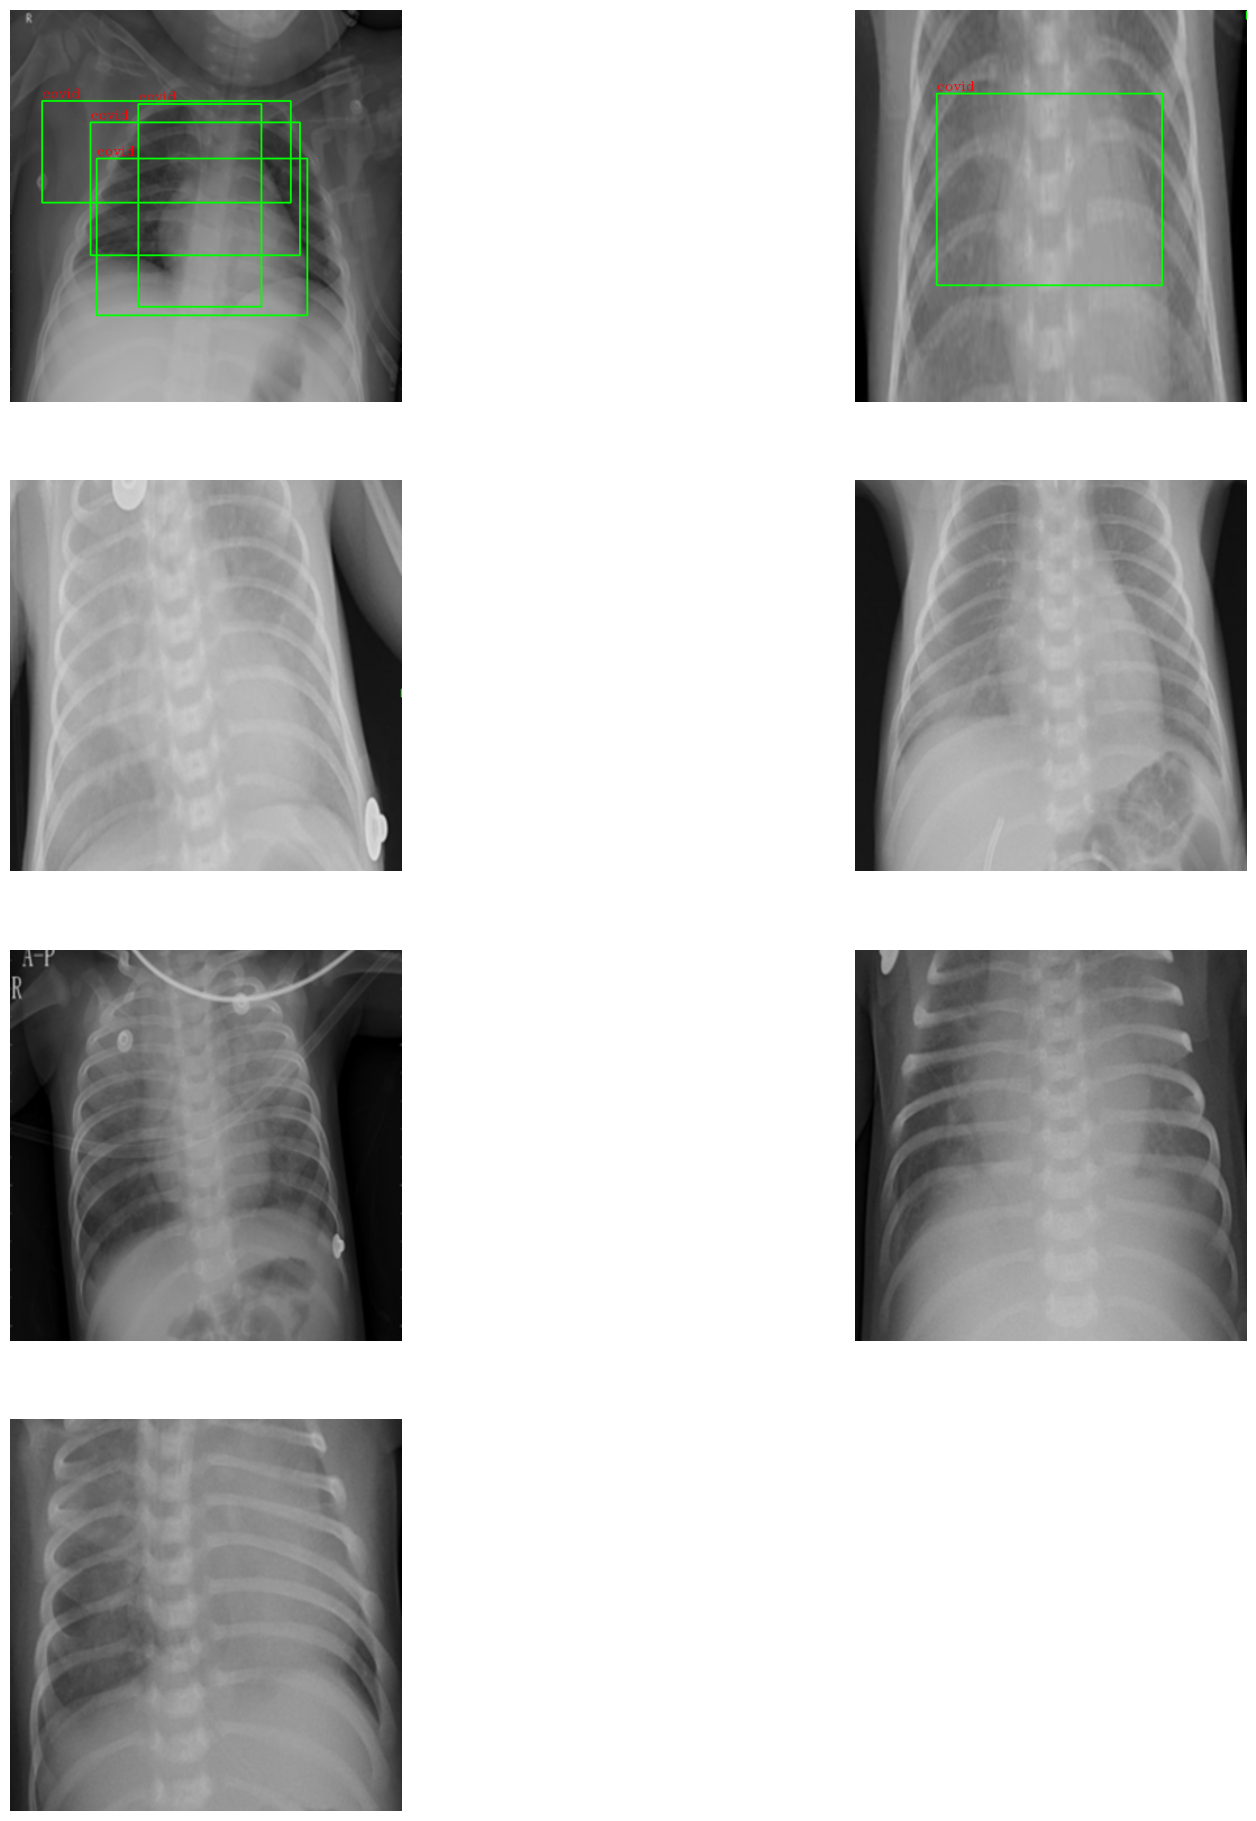

In [ ]:
# pred_path = '/content/drive/MyDrive/Capstone Data (Shared)/Capstone Data/For Object Detection/NoBoxes'
pred_path = '/content/drive/MyDrive/Capstone Data (Shared)/Capstone Data/Test Data (300 images)'
pred_files = [os.path.join(pred_path,f) for f in os.listdir(pred_path)]

plt.figure(figsize=(20,60))
for i, images in enumerate(pred_files):
    if i > 19:break
    plt.subplot(10,2,i+1)
    names,boxes,sample = obj_detector(images)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (int(box[0]), int(box[1])),
                      (int(box[2]), int(box[3])),
                      (0, 220, 0), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]-5),cv2.FONT_HERSHEY_COMPLEX ,0.7,(220,0,0),1,cv2.LINE_AA)

    plt.axis('off')
    plt.imshow(sample)
#     plt.savefig('save_image.png', bbox_inches='tight')  # if you want to save result